In [28]:
setwd("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/MEA-seq")

In [64]:
library(ggplot2)
library(ggrepel)
library(tidyverse)
library(CorLevelPlot)
library(gridExtra)
library(gprofiler2)
library(ggpubr)
library(reshape2)
library(umap)
library(pheatmap)
library(RColorBrewer)


In [30]:
samples_info<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Code/0.Data/RNAseq_data/samples_info.csv")
samples_info$Well_ID <- sub(".*_", "", samples_info$sample)
rownames(samples_info)<-samples_info$sample

In [31]:
data<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Code/0.Data/MEA_data/Processed/Well_summary_parameters_NB_hf_043_06_2025.csv") 
color<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Code/0.Data/cell_lines/colors.csv")
data$color<-color$Color[match(data$Phenotype,color$Phenotype)]
data<-data[data$DIV_range=="DIV49",]
rownames(data)<-data$Unique_ID
data$NB_rate<-data$hf_and_NB_rate - data$hfNB_rate
#Remove the column 'column_name'
data <- data %>% select(-hf_and_NB_rate)
final_selected_variables<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Analysis/DIV28/final_selected_variables_001_top4.csv")

data<-data[data$batch %in% levels(factor(samples_info$MEA)),]
data$sample<-paste0(data$Phenotype,"_",data$Well_Label)

In [32]:
cell_lines<-read.csv("T:/PIgroup Nael NadifKasri/Sofia/2025/MEA_seq_patient/Code/0.Data/cell_lines/cell_lines.csv")
data$cell_line<-cell_lines$cell_line_v2[match(data$Phenotype,cell_lines$Phenotype)]
color$cell_line<-cell_lines$cell_line_v2[match(color$Phenotype,cell_lines$Phenotype)]#try cell_line_v2
data$cell_line<-factor(data$cell_line, levels=cell_lines$order)

In [33]:
data<-data[data$sample %in% samples_info$sample,]
setdiff(samples_info$sample,data$sample)

[1] "EHMT1_CR_F7" "EHMT1_CR_F8"

In [34]:
phenotype_colors <- setNames(color$Color, color$Phenotype)

# Create a named vector for Syndromes and their corresponding MainColors
syndrome_colors <- setNames(color$MainColor, color$Syndrome)

In [35]:
#split controls!
patients<-data[which(data$Syndrome !="Control"), ]
controls<-data[which(data$Syndrome =="Control"), ]

patients<-droplevels(patients)
controls<-droplevels(controls)

In [36]:
patients<-droplevels(patients)

controls<-droplevels(controls)
final_selected_variables<-final_selected_variables$x
pca_meta_controls <- controls %>%
 select(where(is.character) | where(is.factor))
set.seed(1)

In [37]:
controls <- controls %>%
  mutate(across(where(is.character), ~ na_if(.,"")))

In [38]:
#Normalization
numeric_var<-names(controls)[sapply(controls, is.numeric)]

median_individual_controls<-controls %>% group_by(Phenotype)   %>% 
             summarise_at(numeric_var, median) %>% as.data.frame()
median_controls<-median_individual_controls %>% 
             summarise_at(numeric_var, median) %>% as.data.frame()
rownames(median_individual_controls)<-median_individual_controls$Phenotype
median_individual_controls<-median_individual_controls[-1]
rownames(median_controls)<-c("median_controls")
all_control_median_of_medians<-rbind(median_individual_controls,median_controls)

control_min_hfNBrate<-all_control_median_of_medians$hfNB_rate
control_min_hfNBrate<-control_min_hfNBrate[!control_min_hfNBrate==0]
control_min_hfNBrate<-min(control_min_hfNBrate)


#define epsilon
#Convert to numeric matrix to handle all numeric columns
all_values <- unlist(all_control_median_of_medians)

# Keep only numeric and positive values
all_values <- as.numeric(all_values)
all_values <- all_values[all_values > 0]

# # Find the minimum
epsilon <- min(all_values, na.rm = TRUE) * 0.05
# epsilon <-1e-10
print(epsilon)
write.csv(all_control_median_of_medians,"all_control_median_of_medians.csv")


[1] 3.446973e-05


In [39]:
patients$Own_control<-ifelse(patients$isogenic=="yes",patients$Own_control,"median_controls")
patients_meta<-patients %>%  select(where(is.factor) | where(is.character))
patients_normalized<- merge(patients[final_selected_variables], patients_meta, by = 0)
rownames(patients_normalized)<-patients_normalized$Row.names
patients_normalized<-patients_normalized[-1]
patients_normalized_list<-list()
for (r in rownames(patients_normalized)){
    df<-patients_normalized[r,]
    pool_to_norm<-df[,"Own_control"]
    norm_row<-all_control_median_of_medians[pool_to_norm,final_selected_variables]#all_control_medians
  # Add epsilon to both sample and control, then divide
    num_vars <- colnames(df)[colnames(df) %in% numeric_var]
 
    df[, num_vars] <- log2((df[, num_vars] + epsilon) / (norm_row + epsilon))#log2 for making similar up and downreguation differences

    patients_normalized_list[[r]]<-df
}
patients_normalized_list<-do.call(rbind,patients_normalized_list)

pca_meta_patients_normalized_list <- patients_normalized_list %>%
 select(where(is.factor) | where(is.character))
set.seed(1)

pca_fit_patients_normalized_list <- patients_normalized_list %>%
  select(where(is.numeric)) 
# Identify rows with NA values
rows_with_na <- !complete.cases(pca_fit_patients_normalized_list)




In [40]:
patients_num<-patients %>%
  select(where(is.numeric))
# Identify rows with NA values
rows_with_na <- !complete.cases(patients_num)
    
# Output rows with NA values
patients_num[rows_with_na, ]

Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"
Warning message in cbind(parts$left, chars$ellip_h, parts$right, deparse.level = 0L):
"number of rows of result is not a multiple of vector length (arg 2)"


X,Firing_rate_Hz,EB_Dur,EB_Dur_Std,Spikes_per_EB,Spikes_per_EB_Std,EB_ISI,EB_ISI_Std,IEBI,IEBI_Std,⋯,hfNB_rate,NB_prop,NB_dur,NB_dur_Std,Firing_Rate_in_NB_Hz,Firing_Rate_in_NB_Std,INBI,INBI_Std,hfNB_and_NB_prop,NB_rate
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [ ]:
#PCA and UMAP of normalized MEA data

pdf 
  2

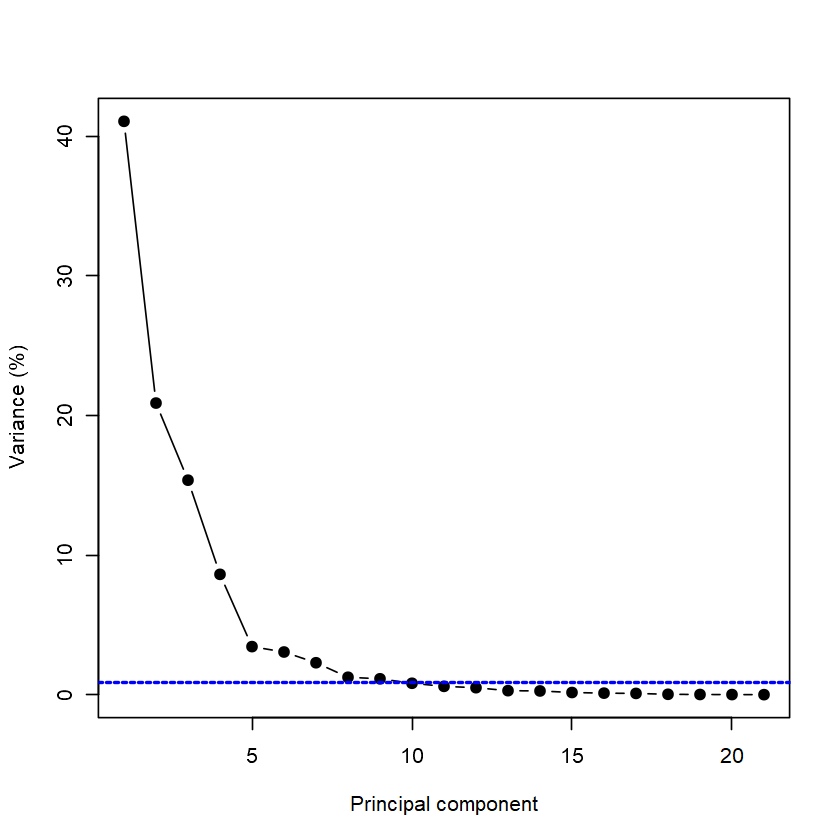

In [41]:
pca_fit_patients_normalized_list<- prcomp(pca_fit_patients_normalized_list, center = FALSE,scale. = TRUE)
pca_fit_patients_normalized_list$rotation <- -1*pca_fit_patients_normalized_list$rotation
summ <- summary(pca_fit_patients_normalized_list)
summ_var<-summ$importance[2,]
summ_var<-unname(summ_var[1:21])
plot(summ_var*100, type = "b", pch = 19, col = "black", 
     xlab = "Principal component", ylab = "Variance (%)")

# Add a line at 1% variance
abline(h = 0.9, col = "blue", lty = 2, lwd = 2)  # Horizontal line at 1%

pdf("PCA_variance_patients.pdf", width = 5, height = 4)

plot(summ_var*100, type = "b", pch = 19, col = "black", 
     xlab = "Principal component", ylab = "Variance (%)")

# Add a line at 1% variance
abline(h = 0.9, col = "blue", lty = 2, lwd = 2)  # Horizontal line at 1%


dev.off()

In [42]:
# Extract the loadings (rotation matrix)
loadings <- pca_fit_patients_normalized_list$rotation
# Extract the proportion of variance explained by each component
explained_variance <- pca_fit_patients_normalized_list$sdev^2 / sum(pca_fit_patients_normalized_list$sdev^2)

setNames(explained_variance, seq_along(explained_variance))

1            2            3            4            5            6 
4.105186e-01 2.088095e-01 1.535982e-01 8.617540e-02 3.444293e-02 3.057830e-02 
           7            8            9           10           11           12 
2.288845e-02 1.251287e-02 1.139903e-02 8.203654e-03 5.986005e-03 5.026904e-03 
          13           14           15           16           17           18 
2.897730e-03 2.694500e-03 1.594926e-03 1.125306e-03 9.295653e-04 3.148832e-04 
          19           20           21 
1.629873e-04 1.033757e-04 3.696854e-05

In [43]:
# #PC > #0.4% variance
threshold<-0.004 #0.4% 
selected_components  <- max(which(round(explained_variance,3) >= threshold))
selected_components
#14 to be consistent with DIV28

[1] 12

In [44]:
pca_pc_metrics<-as.data.frame(pca_fit_patients_normalized_list$x)
pca_pc_metrics$Unique_ID<-rownames(pca_pc_metrics)
pca_pc_metrics<-inner_join(pca_pc_metrics,pca_meta_patients_normalized_list, by="Unique_ID")
rownames(pca_pc_metrics)<-pca_pc_metrics$Unique_ID
var_explained =round((pca_fit_patients_normalized_list$sdev^2 / sum(pca_fit_patients_normalized_list$sdev^2))*100,2)
length(levels(factor(pca_pc_metrics$Phenotype)))
length(levels(factor(pca_pc_metrics$Syndrome)))

[1] 9

[1] 6

In [45]:
# Create a named vector for Phenotypes and their corresponding Colors
phenotype_colors <- setNames(color$Color, color$cell_line)

# Create a named vector for Syndromes and their corresponding MainColors
syndrome_colors <- setNames(color$MainColor, color$Syndrome)

In [47]:
write.csv(pca_pc_metrics,"pca_pc_metrics.csv")

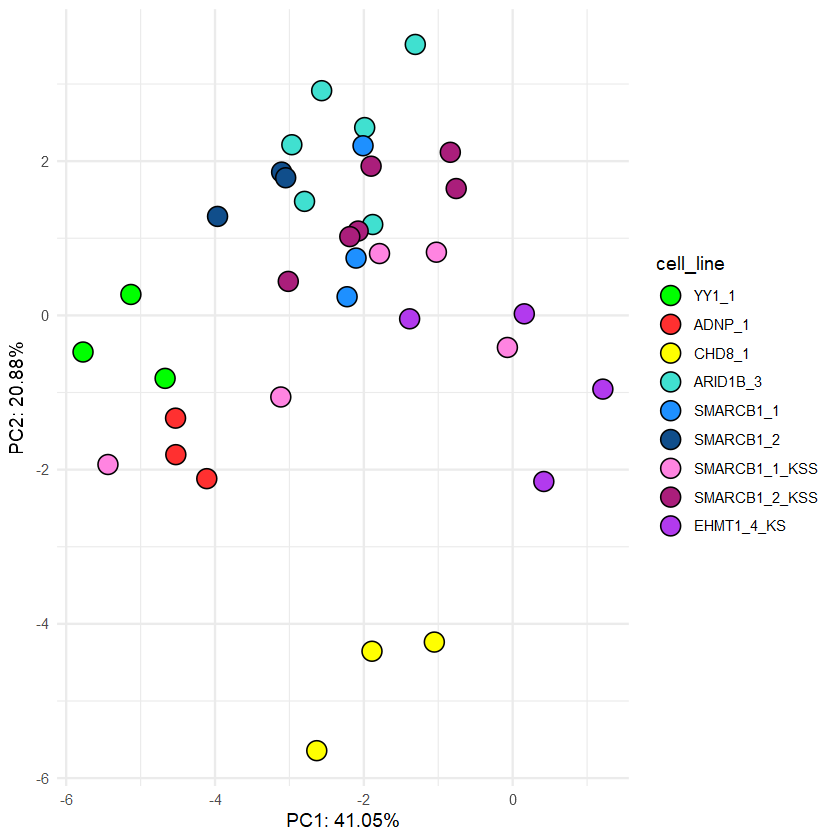

In [48]:
p<-ggplot(pca_pc_metrics, aes(PC1, PC2, fill=cell_line)) +
  geom_point(size=5,shape = 21, # Specify shape and colour as fixed local parameters    
             colour = "black") +  scale_fill_manual(values=phenotype_colors)+ 
           theme_minimal()+ 
      
  xlab(paste0("PC1: ",var_explained[1],"%")) +
  ylab(paste0("PC2: ",var_explained[2],"%"))
p


ggsave("PCA_patients_normalized_line.pdf",bg = "transparent",
                  width = 5.3,   # inches
                  height = 5,
                   plot=p# inches
)

In [49]:
library(proxy)  # Required for cosine distance

calculate_pairwise_distance <- function(cell_line_1, cell_line_2, umap_df) {
    # Extract UMAP points for both cell lines
    umap_1 <- umap_df[umap_df$cell_line == cell_line_1, c("UMAP1", "UMAP2")]
    umap_2 <- umap_df[umap_df$cell_line == cell_line_2, c("UMAP1", "UMAP2")]

    # If either cell line has fewer than two UMAP points, return NA
    if (nrow(umap_1) < 2 | nrow(umap_2) < 2) {
        return(NA)
    }

    # If the cell lines are the same, return 0 for self-comparison
    if (cell_line_1 == cell_line_2) {
        return(0)
    } else {
        # Compute pairwise cosine distances between umap_1 and umap_2
        dist_matrix <- proxy::dist(rbind(umap_1, umap_2), method = "cosine")  
        dist_matrix <- as.matrix(dist_matrix)  # Convert to matrix format
        dist_matrix <- dist_matrix[1:nrow(umap_1), (nrow(umap_1) + 1):ncol(dist_matrix)]  # Subset
        
        return(mean(dist_matrix, na.rm = TRUE))  # Return the mean cosine distance
    }
}



Attaching package: 'proxy'


The following objects are masked from 'package:stats':

    as.dist, dist


The following object is masked from 'package:base':

    as.matrix




In [55]:
custom.config <- umap.defaults
custom.config$random_state <- 123

In [56]:
pca_meta_patients <- patients %>%
 select(where(is.factor) | where(is.character))
set.seed(1)

In [57]:
# Define an 8-color washed-out palette
washed_out_palette <- c("#D3D3D3",  # Light Gray
                        "#B0C4DE",  # Light Steel Blue
                        "#C8A2C8",  # Lilac
                        "#E6BEAE",  # Washed-out Peach
                        "#B5C2B7",  # Muted Sage Green
                        "#F0EAD6",  # Eggshell
                        "#A7BED3",  # Soft Blue Gray
                        "#C4A484")  # Faded Sand


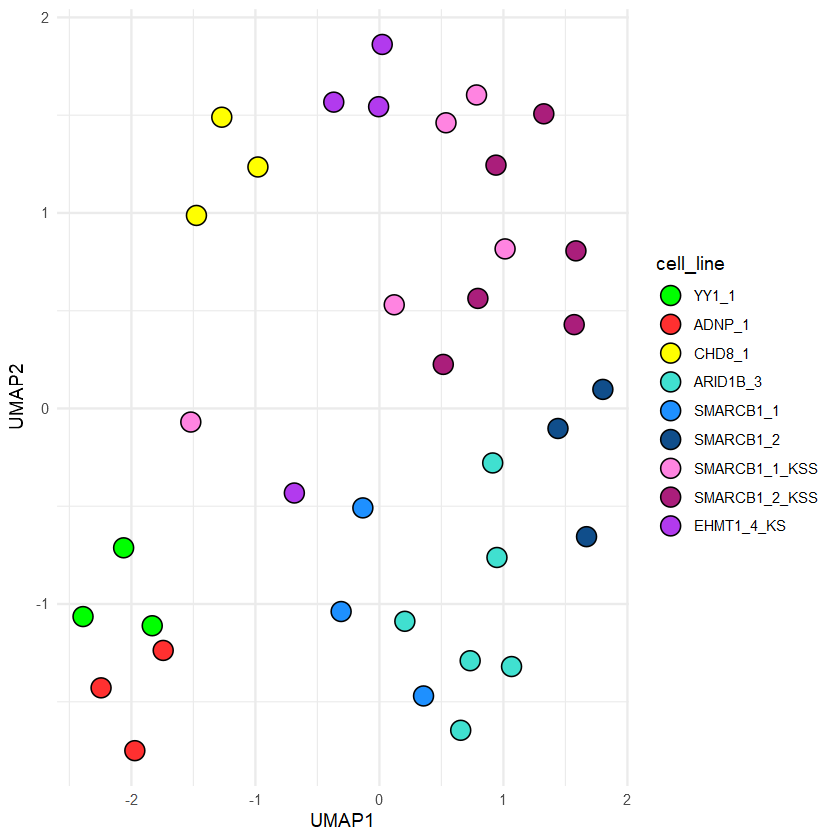

In [60]:
ggplot(umap_df, aes(UMAP1, UMAP2,  fill=cell_line)) +
    geom_point(size=5,shape = 21, # Specify shape and colour as fixed local parameters    
             colour = "black") +  scale_fill_manual(values=phenotype_colors)+
           theme_minimal()

Warning message in dir.create(paste0("PC", n.components)):
"'PC13' already exists"


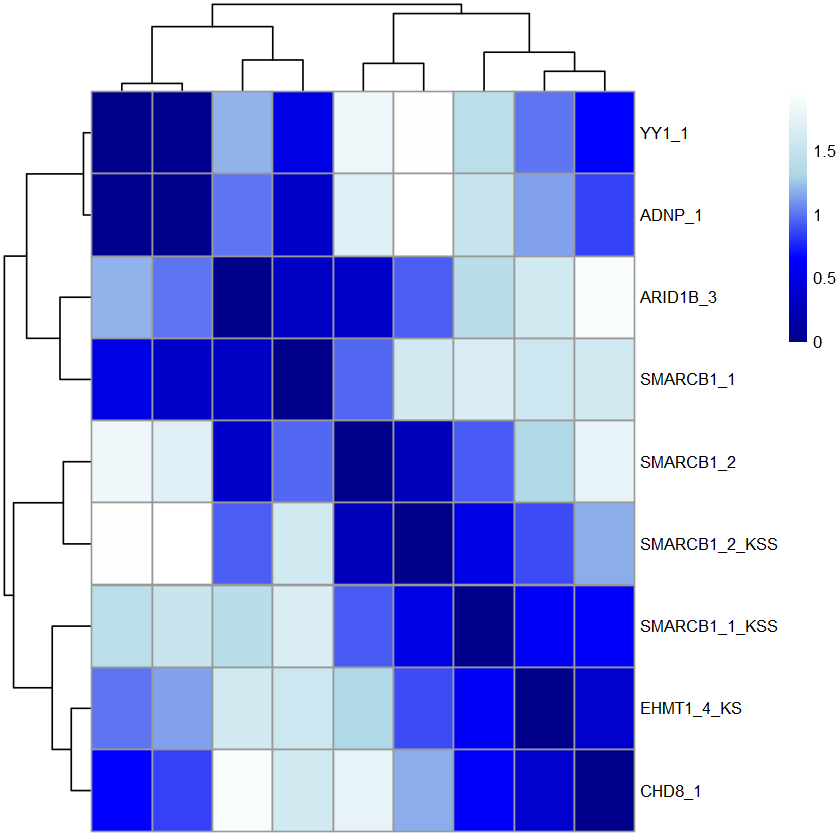

Warning message in dir.create(paste0("PC", n.components, "/hier")):
"'PC13\hier' already exists"
Warning message in dir.create(paste0("PC", n.components, "/hier/", num_clusters)):
"'PC13\hier\4' already exists"
Using cell_line, Well_Label, Phenotype, batch, cell_line_batch, machine, PT_all_path, DIV_range, Syndrome, Gene, Identidy, Own_control, isogenic, Remarks, Pool_Kleefstra, Pool_WTC_CHD2, Pool_CACNA1A, Pool_SMARCB1, Pool_ARID1B_2_rescue, Pool_dravet, Unique_ID, PT_all_path_Well_Label, DIV49_sub, dev_sub, color, sample, hier_clust as id variables



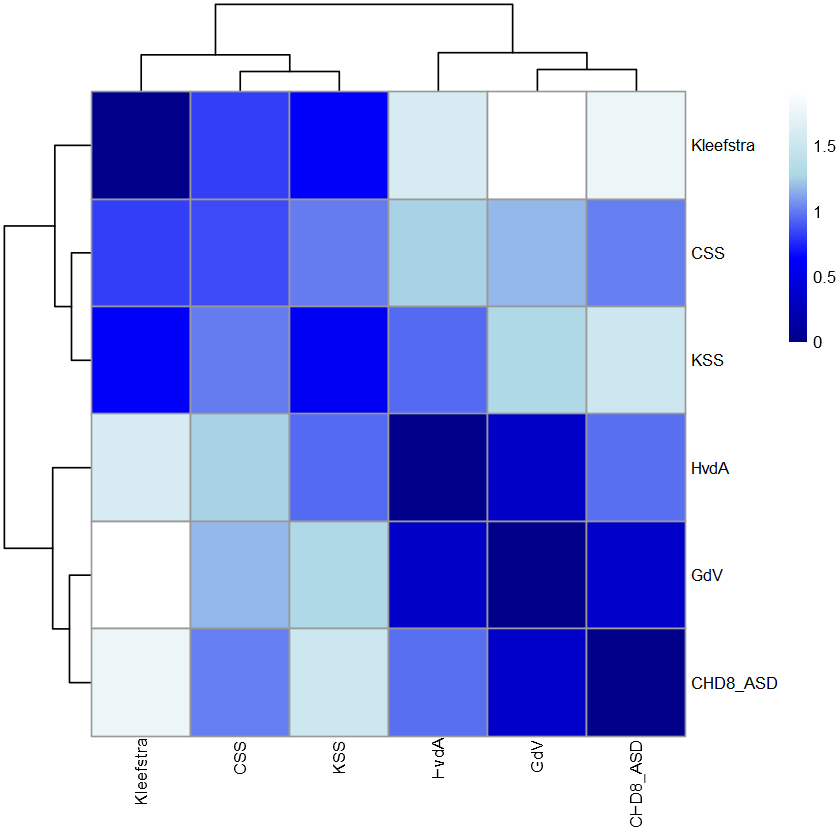

Warning message in dir.create(paste0("PC", n.components, "/hier/", num_clusters, :
"'PC13\hier\4\individual_plots' already exists"
Warning message in geom_violin(outlier.shape = NA, size = 0.5, colour = "grey", :
"Ignoring unknown parameters: `outlier.shape`"
Warning message in geom_violin(outlier.shape = NA, size = 0.5, colour = "grey", :
"Ignoring unknown parameters: `outlier.shape`"
Warning message in geom_violin(outlier.shape = NA, size = 0.5, colour = "grey", :
"Ignoring unknown parameters: `outlier.shape`"
Warning message in geom_violin(outlier.shape = NA, size = 0.5, colour = "grey", :
"Ignoring unknown parameters: `outlier.shape`"
Warning message in geom_violin(outlier.shape = NA, size = 0.5, colour = "grey", :
"Ignoring unknown parameters: `outlier.shape`"
Warning message in geom_violin(outlier.shape = NA, size = 0.5, colour = "grey", :
"Ignoring unknown parameters: `outlier.shape`"
Warning message in geom_violin(outlier.shape = NA, size = 0.5, colour = "grey", :
"Ignoring unk

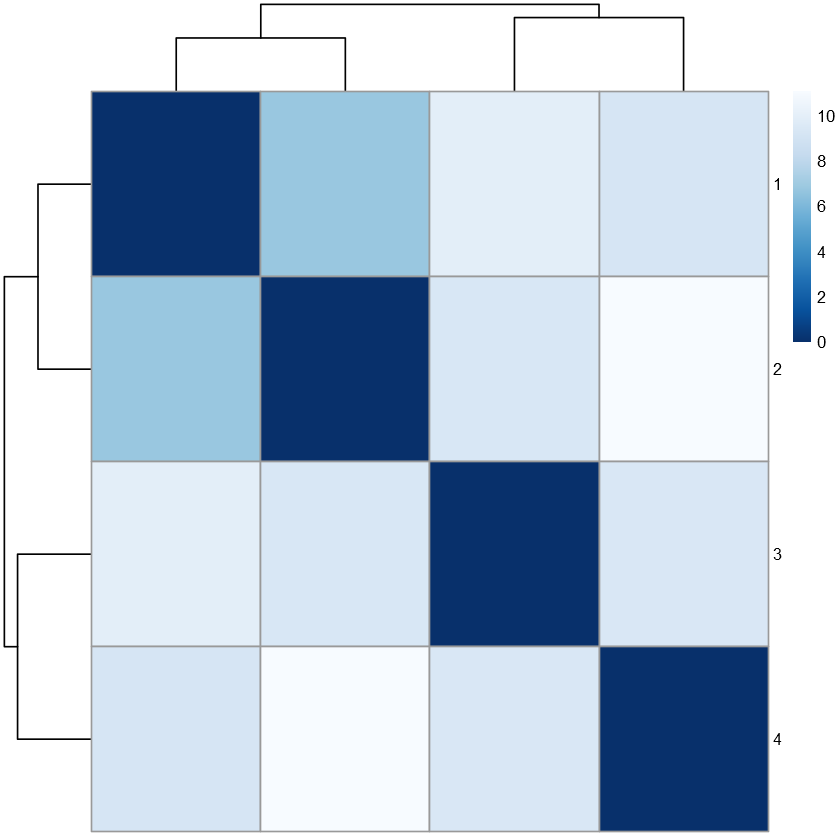

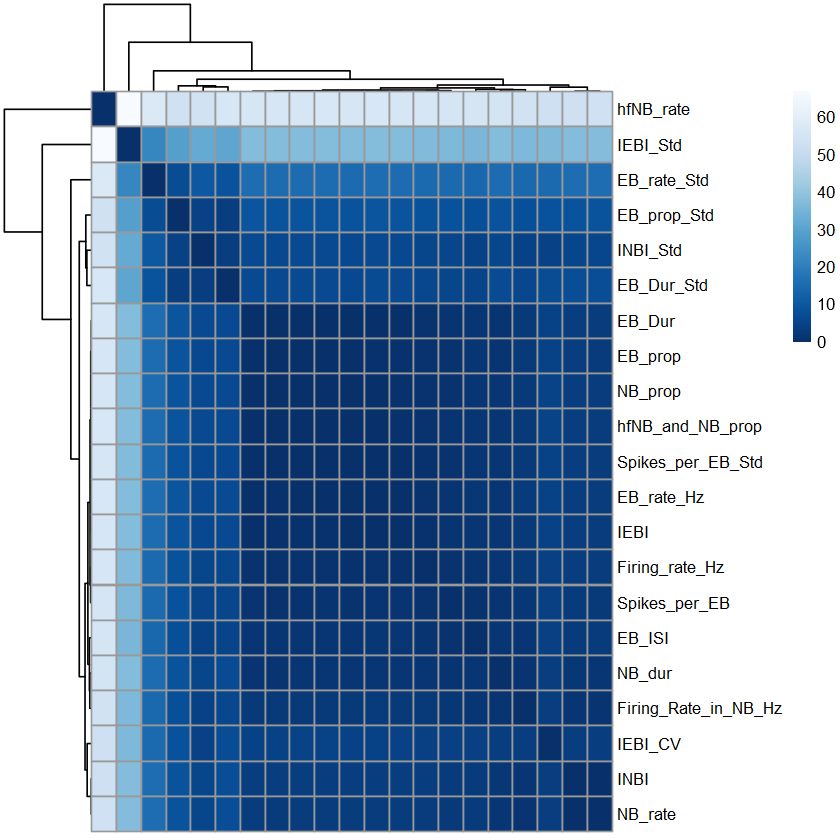

In [66]:
n_colors=c("1"="#8896A0","2"="#FFFF00","3"="#9933FF","4"="#99CC99","5"="#FFCCFF","6"="#339999","7"="#FFCC99",
          "8"="#FF3300","9"="#0000FF","10"="#66FFFF","11"="#FF9933","12"="#CCCC00")

for (n in 13){  #consitent with previous DIVs
    n.components=n
    dir.create(paste0("PC",n.components))
    pca_pc_metrics_umap<-pca_pc_metrics[,1:n.components]
    pca_pc_metrics_umap$Unique_ID<-rownames(pca_pc_metrics_umap)
    pca_pc_metrics_umap<-inner_join(pca_pc_metrics_umap,pca_meta_patients, by="Unique_ID")

    rownames(pca_pc_metrics_umap)<-pca_pc_metrics_umap$Unique_ID
    umap_meta <- pca_pc_metrics_umap %>%  select(where(is.factor) | where(is.character))
    umap_fit<-pca_pc_metrics_umap %>%
              select(where(is.numeric))  %>%
              umap(config=custom.config)
    umap_df <- umap_fit$layout %>%
      as.data.frame()
    colnames(umap_df)<-c("UMAP1","UMAP2")
    umap_df$Unique_ID<-rownames(umap_df)
    umap_df<-inner_join(umap_df,pca_pc_metrics_umap, by="Unique_ID")
    rownames(umap_df)<-umap_df$Unique_ID
    
    p<-ggplot(umap_df, aes(UMAP1, UMAP2,  fill=cell_line)) +
    geom_point(size=5,shape = 21, # Specify shape and colour as fixed local parameters    
             colour = "black") +  scale_fill_manual(values=phenotype_colors)+
           theme_minimal()
       

    ggsave(paste0("PC",n.components,"/UMAP_cell_line.pdf"),bg = "transparent",
                  width = 5.3,   # inches
                  height = 5,   # inches
                plot=p
            )
    

    p<-ggplot(umap_df, aes(UMAP1, UMAP2,  fill=cell_line)) +
    geom_point(size=5,shape = 21, # Specify shape and colour as fixed local parameters    
             colour = "black") +  scale_fill_manual(values=phenotype_colors)+
           theme_minimal()+    
       geom_text(aes(label = Well_Label))


    ggsave(paste0("PC",n.components,"/UMAP_cell_line_label.pdf"),bg = "transparent",
                  width = 5.3,   # inches
                  height = 5,   # inches
                plot=p
        )
    
    
 
# Create a matrix for storing pairwise distances between cell lines
    unique_cell_lines <- unique(umap_df$cell_line)
    pairwise_distances_matrix <- matrix(NA, nrow = length(unique_cell_lines), ncol = length(unique_cell_lines))
    rownames(pairwise_distances_matrix) <- unique_cell_lines
    colnames(pairwise_distances_matrix) <- unique_cell_lines
    # Loop through all pairs of cell lines and calculate the pairwise distance
    for (i in 1:(length(unique_cell_lines) - 1)) {
        for (j in (i + 1):length(unique_cell_lines)) {
            cell_line_i <- unique_cell_lines[i]
            cell_line_j <- unique_cell_lines[j]
            
            # Calculate the distance between the pair of cell lines
            pairwise_distances_matrix[i, j] <- calculate_pairwise_distance(cell_line_i, cell_line_j, umap_df)
            pairwise_distances_matrix[j, i] <- pairwise_distances_matrix[i, j]  # Symmetric distance
        }
    }

    # Replace the diagonal (self-distances) with zero directly
    diag(pairwise_distances_matrix) <- 0

    # Plot heatmap for pairwise distances between cell lines
    #colors <- colorRampPalette(brewer.pal(9, "YlGnBu"))(255)  # Yellow-Green-Blue
    colors <- colorRampPalette(c( "darkblue","blue","lightblue","white"  ))(250)

    
    p <- pheatmap(pairwise_distances_matrix,
                  col = colors,
                  show_colnames = FALSE,  # Hide x-axis labels
              show_rownames = TRUE,   # Keep y-axis labels
                  #breaks = seq(0, 2, length.out = 256),
                  angle_col = 90)


    ggsave(paste0("PC",n.components,"/UMAP_distance_cell_line_cosine.pdf"),bg = "transparent",
                  width = 5.5,   # inches
                  height = 4,   # inches
                plot=p
        )
    
    # Calculate distance between syndromes
    syndrome_names <- unique(umap_df$Syndrome)
    syndrome_dist_matrix <- matrix(NA, nrow = length(syndrome_names), ncol = length(syndrome_names))
    rownames(syndrome_dist_matrix) <- syndrome_names
    colnames(syndrome_dist_matrix) <- syndrome_names
    
    for (i in 1:length(syndrome_names)) {
        for (j in i:length(syndrome_names)) {
            syndrome_i <- syndrome_names[i]
            syndrome_j <- syndrome_names[j]
            
            # Get the cell lines for each syndrome
            cell_lines_i <- unique(umap_df$cell_line[umap_df$Syndrome == syndrome_i])
            cell_lines_j <- unique(umap_df$cell_line[umap_df$Syndrome == syndrome_j])
            
            # Get the pairwise distances between all cell lines within each syndrome
            if (i == j) {
                # Intra-syndrome distance: calculate mean pairwise distance between cell lines within the same syndrome
                dist_subset <- pairwise_distances_matrix[cell_lines_i, cell_lines_i]
                syndrome_dist_matrix[i, j] <- mean(dist_subset, na.rm = TRUE)
            } else {
                # Inter-syndrome distance: calculate mean pairwise distance between cell lines of two different syndromes
                dist_subset <- pairwise_distances_matrix[cell_lines_i, cell_lines_j]
                syndrome_dist_matrix[i, j] <- mean(dist_subset, na.rm = TRUE)
                syndrome_dist_matrix[j, i] <- syndrome_dist_matrix[i, j]  # Fill symmetric value
            }
        }
    }
    
    # Plot heatmap for syndrome distances
    syndrome_dist_matrix[is.na(syndrome_dist_matrix)] <- 0 # This is for syndromes with only one cell line
    #colors <- colorRampPalette(brewer.pal(9, "YlGnBu"))(255)  # Yellow-Green-Blue
    colors <- colorRampPalette(c( "darkblue","blue","lightblue","white"  ))(250)
  
    p <- pheatmap(syndrome_dist_matrix,
                  col = colors,
                #breaks = seq(0, 2, length.out = 256),
                  angle_col = 90)


    ggsave(paste0("PC",n.components,"/UMAP_distance_syndrome_cosine.pdf"),bg = "transparent",
                  width = 4,   # inches
                  height = 4,   # inches
                plot=p
        )
    
    
    # Save or process the distance matrices as needed
    UMAP_order<-p[[4]][[1]][[3]][[4]][[1]][[9]][[1]]
    UMAP_order<-rownames(UMAP_order)


# #add hierarchical clustering                             
    dir.create(paste0("PC",n.components,"/hier"))
    PC<-umap_df
    hc <- hclust(dist(PC[1:2]), method = "complete")
     # Define the number of clusters you want
    for (num_clusters in 4){  # Adjust as needed
        # Cut the tree to obtain the specified number of clusters
        clusters <- cutree(hc, k = num_clusters)
        dir.create(paste0("PC",n.components,"/hier/",num_clusters))
        # Print the cluster assignments
        clusters<-data.frame(clusters)
        clusters$Unique_ID<-rownames(clusters)
        umap_df$hier_clust<-factor(clusters$clusters[match(umap_df$Unique_ID,
                                                          clusters$Unique_ID)])
        num_levels <- as.numeric(as.character(umap_df$hier_clust))

        # Get the maximum value
        max_value <- max(num_levels, na.rm = TRUE)
        
        # Assign the new value (example: increment by 1)
        new_value <- max_value + 1
        
        
        umap_df_syndrome<-split(umap_df,f=umap_df$Syndrome)
        umap_df_syndrome<- lapply(umap_df_syndrome, function(x) table(x$cell_line,x$hier_clust))
        for(df in names(umap_df_syndrome)){
            rel_counts<-umap_df_syndrome[[df]]

            for (i in 1:nrow(rel_counts)){
            rel_counts[i,] <- (prop.table(rel_counts[i,]))*100 }
            rel_counts<-as.data.frame(rel_counts)
            rel_counts$Syndrome<-df
            umap_df_syndrome[[df]]<-rel_counts}

        for(df in names(umap_df_syndrome)){
            data<-umap_df_syndrome[[df]]
            data <- data[data$Freq != "NaN", ]
            umap_df_syndrome[[df]]<-data}
        umap_df_syndrome<-as.data.frame(do.call(rbind,umap_df_syndrome))
        colnames(umap_df_syndrome)<-c("cell_line","cluster","percentage","syndrome")
        p<-ggplot(umap_df_syndrome, aes(x=cell_line, y=percentage, fill = cluster)) + 
                geom_bar(stat = "identity") + scale_fill_manual(values=n_colors)+
                theme_minimal()+
                theme(axis.text.x = element_text(size=7,angle = 45, vjust = 1, hjust = 1, color="black"),
                        axis.text.y = element_text(size=7, color="black"), strip.text = element_text(size = 7), 
                        axis.title.x = element_text(size = 8, color="black"),#,face="bold"
                        axis.title.y = element_text(size = 8, color="black"),
                        legend.title = element_text(size = 7),  # Reduce legend title size
                        legend.key.size = unit(0.4, "cm"), 
                        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
                        panel.background = element_blank()) + facet_wrap(~syndrome,scales = "free",ncol=3)
                                  


        ggsave(paste0("PC",n.components,"/hier/",num_clusters,"/cell_line_proportion.pdf"),bg = "transparent",
                  width = 4,   # inches
                  height = 4,   # inches
                plot=p
        )
                                  
        patients_normalized_hier5<-left_join(patients_normalized_list,umap_df[, colnames(umap_df) %in% c("hier_clust","Unique_ID")], by="Unique_ID")
        patients_normalized_hier5$hier_clust<-as.factor(patients_normalized_hier5$hier_clust)
        rownames(patients_normalized_hier5)<-patients_normalized_hier5$Unique_ID
        patients_normalized_hier5_melted<-melt(patients_normalized_hier5)
        patients_normalized_hier5_melted_list<-split(patients_normalized_hier5_melted, f=patients_normalized_hier5_melted$variable)
        variables_to_test<-names(patients_normalized_hier5_melted_list)
        write.csv(patients_normalized_hier5,paste0("PC",n.components,"/hier/",num_clusters,"/patients_normalized_hier.csv"))
        write.csv(patients_normalized_hier5,paste0("patients_normalized_hier_PC",n.components,".csv")) #write it to the general path as well

        clusters<-levels(patients_normalized_hier5_melted$hier_clust)
        all_comparisons<-list()
        for (var in variables_to_test){
            cluster_list<-list()
            df<-patients_normalized_hier5_melted_list[[var]]
                    
            for(cluster in clusters){
                 
                    # Subset data to current cluster only
                    df_c <- df[df$hier_clust == cluster, ]   
                        
                    #results<-lm(value ~ evaluated_cluster, data=df_c)
                 # Fit intercept-only model: value ~ 1, testing mean != 0
                    results <- lm(value ~ 1, data = df_c)    
                        
                    results<-summary(results)
                    results<-as.data.frame(results$coefficients)
                       
                    results_2<-data.frame("intercept"=results[1,1],#"estimate"=results[2,1],
                                     "p_val"=results[1,4])  # p-value for intercept #"p_val"=results[2,4] for coef
                    results_2$evaluated_cluster_number<-cluster
                    results_2$metric<-var
                    results_2$fold_change <- 2^(abs(results_2$intercept))  # replaced estimate by intercept interpret directly
                    results_2$signed_fold_change <- ifelse(
                    results_2$intercept >= 0,
                    results_2$fold_change,
                    -results_2$fold_change
                       )
                    results_2$percent_change <- (2^(results_2$intercept) - 1) * 100
                    results_2$estimate<-results_2$intercept #so dont need to adjust all the code below
                    cluster_list[[cluster]]<-results_2
                        
                    }
            
            
                    
            cluster_list<-do.call(rbind,cluster_list)
            all_comparisons[[var]]<-cluster_list
                
                }
        all_comparisons<-do.call(rbind,all_comparisons)
        all_comparisons$adj_p<-p.adjust(all_comparisons$p_val, method ="fdr", n = dim(all_comparisons)[1])
        all_comparisons$significant<-ifelse(abs(all_comparisons$estimate) > 0 & all_comparisons$p_val<=0.05, TRUE, FALSE)#only positive for interpretation
        all_comparisons_significant<-all_comparisons[all_comparisons$significant==TRUE,]
        all_comparisons_significant_list<-split(all_comparisons_significant,f=all_comparisons_significant$evaluated_cluster_number)
        write.csv(all_comparisons_significant,paste0("PC",n.components,"/hier/",num_clusters,"/all_comparisons_significant.csv"))
            #include an if for propr_active_electrodes and use binomial!
        #for_hier_c<-as.data.frame.matrix(t(table(all_comparisons$metric,all_comparisons$evaluated_cluster_number)))
          
        #  Select relevant columns (estimate values for distance calculation)
        filtered_data <- all_comparisons %>%
              select(evaluated_cluster_number, metric, estimate)
            
            # Reshape data: Wide format with clusters as rows and metrics as columns
        wide_data <- filtered_data %>%
              pivot_wider(names_from = metric, values_from = estimate, values_fill = 0)  # Fill missing values with 0
            
            #  Convert evaluated_cluster_number to row names
        wide_data <- wide_data %>%
              column_to_rownames(var = "evaluated_cluster_number")
            
            # Scale the estimates to give all metrics equal weight
        scaled_data <- scale(wide_data)
            
            #  Compute distance matrix
        cluster_distances <- dist(scaled_data)
            
            
        for_hier_c_Dists <- stats::dist(cluster_distances)                          
        for_hier_c_DistsMatrix <- as.matrix(for_hier_c_Dists)
            #rownames(sampleDistMatrix) <- paste(vsd$sampleSpecificCondition, vsd$type, sep="-")
        colnames(for_hier_c_DistsMatrix) <- NULL
        colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
            
        pheatmap<-pheatmap(for_hier_c_DistsMatrix,
                    clustering_distance_rows=for_hier_c_Dists,
                    clustering_distance_cols=for_hier_c_Dists,
                    col=colors)


        ggsave(paste0("PC",n.components,"/hier/",num_clusters,"/clusters_distances.pdf"),bg = "transparent",
                  width = 3,   # inches
                  height = 3,   # inches
                plot=pheatmap
        )   
        order_of_clusters<-pheatmap[[4]][[1]][[3]][[4]][[1]][[9]][[1]]
        order_of_clusters<-rownames(order_of_clusters)
        umap_df$hier_clust<-factor(umap_df$hier_clust,levels=order_of_clusters)
            
        p<-ggplot(umap_df, aes(UMAP1, UMAP2, fill=hier_clust)) +
              geom_point(size=5,shape = 21, # Specify shape and colour as fixed local parameters    
                         colour = "black") +theme_minimal()+scale_fill_manual(values=n_colors)
    
            
        ggsave(paste0("PC",n.components,"/hier/",num_clusters,"/UMAP_cluster.pdf"),bg = "transparent",
                  width = 5.3,   # inches
                  height = 5,   # inches
                plot=p
        )   
            
        patients_normalized_hier5_melted$hier_clust<-factor(patients_normalized_hier5_melted$hier_clust, levels=order_of_clusters)
        dir.create(paste0("PC",n.components,"/hier/",num_clusters,"/individual_plots"))
        for (var in names(patients_normalized_hier5_melted_list)){
                
            df<-patients_normalized_hier5_melted_list[[var]]
            df$Phenotype_Well_Label<-paste0(df$Phenotype,df$Well_Label)
            plot<-ggplot(df,aes(x=hier_clust,y=value,fill=hier_clust,group =hier_clust))+
            geom_violin(outlier.shape = NA,size=0.5,colour = "grey",alpha = 0.5)+ 
                stat_summary(fun = "mean",
                           geom = "crossbar",
                           color = "grey")+scale_fill_manual(values=n_colors) +
                 xlab("") +ylab("")+
                geom_point(position = position_jitterdodge(), alpha=1,shape=21,size = 0.3)+
           geom_text(aes(label = Well_Label), size=2)+
                #geom_jitter(aes(fill=group),size = 3,position = position_jitter(seed = 2,w = 0.01, h = 0),shape=21)+
                #scale_colour_manual(values=palette15)+
                
                  theme_minimal()+theme(axis.text.x=element_text(size=8,color="black"),#,angle=90,hjust=1,vjust=0.5, 
                                     axis.text.y=element_text(size=8,color="black"),
                                  axis.title=element_text(size=8),text=element_text(size=7))+ ggtitle(paste0(var))+ theme(legend.position="none")
                
    
            ggsave(paste0("PC",n.components,"/hier/",num_clusters,"/individual_plots/",var,".pdf"),bg = "transparent",
                  width = 2,   # inches
                  height = 2,   # inches
                plot=plot
        )        
                
                
            }
            
        all_comparisons_hm<-all_comparisons[,colnames(all_comparisons) %in% c("evaluated_cluster_number","metric","signed_fold_change","adj_p","p_val","estimate")]
        all_comparisons_hm$evaluated_cluster_number<-as.factor(all_comparisons_hm$evaluated_cluster_number)
        all_comparisons_hm$metric<-as.factor(all_comparisons_hm$metric)
        all_comparisons_hm$r_adj_p<-round(all_comparisons_hm$adj_p,2)
        all_comparisons_hm$r_p_val<-round(all_comparisons_hm$p_val,2)
        min_fc<-min(all_comparisons_hm$signed_fold_change)
        max_fc<-max(all_comparisons_hm$signed_fold_change)
            
        all_comparisons_hm$evaluated_cluster_number<-factor(all_comparisons_hm$evaluated_cluster_number, levels=order_of_clusters)

        median_fc<-median(all_comparisons_hm$fold_change[all_comparisons_hm$fold_change>0])
            
        clusters<-levels(patients_normalized_hier5_melted$hier_clust)
        all_comparisons<-list()
        for (var in variables_to_test){
            cluster_list<-list()
            df<-patients_normalized_hier5_melted_list[[var]]
                
            for(cluster in clusters){
                    
                df_c <- df[df$hier_clust == cluster, ]   
                        
                  
                results <- lm(value ~ 1, data = df_c)    
                        
                results<-summary(results)
                results<-as.data.frame(results$coefficients)
                       
                results_2<-data.frame("intercept"=results[1,1],#"estimate"=results[2,1],
                                     "p_val"=results[1,4])  # p-value for intercept #"p_val"=results[2,4] for coef
                results_2$evaluated_cluster_number<-cluster
                results_2$metric<-var
                    #results_2$fold_change<-results_2$estimate/results_2$intercept
                #modified here to be compatible with log2
                results_2$fold_change <- 2^(abs(results_2$intercept))  # replaced estimate by intercept interpret directlyy
                
                results_3<-matrix(results_2["fold_change"])
                rownames(results_3)<-var
                colnames(results_3)<-cluster
                results_3<-as.data.frame(results_3)
                cluster_list[[cluster]]<-results_3
                    
                }
                ###
             
                
                
            cluster_list<-do.call(cbind,cluster_list)
            all_comparisons[[var]]<-cluster_list
                
            }
        for_hier<-do.call(rbind,all_comparisons)
        for_hier_c_Dists <- stats::dist(for_hier)
            
        for_hier_c_DistsMatrix <- as.matrix(for_hier_c_Dists)
            #rownames(sampleDistMatrix) <- paste(vsd$sampleSpecificCondition, vsd$type, sep="-")
        colnames(for_hier_c_DistsMatrix) <- NULL
        colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
            
        pheatmap<-pheatmap(for_hier_c_DistsMatrix,
                     clustering_distance_rows=for_hier_c_Dists,
                     clustering_distance_cols=for_hier_c_Dists,
                     col=colors)
            
        order_of_metrics<-pheatmap[[4]][[1]][[3]][[4]][[1]][[9]][[1]]
        order_of_metrics<-rownames(order_of_metrics)
  
        max_abs_est <- max(abs(all_comparisons_hm$estimate))
            
        all_comparisons_hm$metric<-factor(all_comparisons_hm$metric, levels=order_of_metrics)
        hm<-ggplot(all_comparisons_hm, aes(x=evaluated_cluster_number, y=metric))+
            geom_tile(aes(fill= estimate),color = "black")+
                scale_fill_gradient2(low="blue", high="red", mid = "white",midpoint = 0,limits=c(-max_abs_est, max_abs_est))+#max(all_comparisons_hm$fold_change_lim)
               
                geom_text(aes(label=r_p_val),colour=ifelse(all_comparisons_hm$r_p<0.01, "black", alpha("white",0)),size=3,angle=45)+
            theme_minimal()+ theme(legend.key.size = unit(0.5, 'cm'),axis.text = element_text (color="black"),
                               legend.key.height = unit(0.5, 'cm'), #change legend key height
                            legend.key.width = unit(0.5, 'cm'), #change legend key width
                            legend.title = element_text(size=7), #change legend title font size
                            legend.text = element_text(size=7,color="black")) +xlab("cluster")+ylab(" ")
            

            
         ggsave(paste0("PC",n.components,"/hier/",num_clusters,"/clust_differences.pdf"),bg = "transparent",
                  width = 3.5,   # inches
                  height = 4,   # inches
                plot=hm
        )      
            
            
        patients_normalized_hier5$cell_line<-paste0(patients_normalized_hier5$Syndrome,"_",patients_normalized_hier5$Phenotype)
        hier5_assigns_prop<-table(patients_normalized_hier5$cell_line,patients_normalized_hier5$hier_clust )#later per phenotype to explore
            #hier5_assigns_prop
        for_hier<-as.matrix(hier5_assigns_prop)
            #for_hier<-for_hier %>%
             # as.data.frame.matrix() %>%   setNames(c('cluster_1', 'cluster_2', 'cluster_3', 'cluster_5'))
            
        for_hier<-t(apply(for_hier,1, function(x) x/sum(x)))
            
        for_hier<-as.matrix(hier5_assigns_prop)
        for_hier<-t(apply(for_hier,1, function(x) x/sum(x)))
            
            
        rel_counts <- table(patients_normalized_hier5$cell_line,patients_normalized_hier5$hier_clust )
            
        for (i in 1:nrow(rel_counts)){
        rel_counts[i,] <- (prop.table(rel_counts[i,]))*100 }
            
 
            
            # make a dataframe of the relative counts
        dg <- as.data.frame(rel_counts)
        colnames(dg) <- c("Syndrome", "cluster", "percentage")
            
        hier5_assigns_prop<-table(umap_df$Syndrome,umap_df$hier_clust )#later per phenotype to explore
            #hier5_assigns_prop
        for_hier<-as.matrix(hier5_assigns_prop)
     
            

        rel_counts <- table(umap_df$Syndrome,umap_df$hier_clust )
                        # calculate the relative counts
        for (i in 1:nrow(rel_counts)){
        rel_counts[i,] <- (prop.table(rel_counts[i,]))*100 }
                        
                        # make a dataframe of the relative counts
        dg <- as.data.frame(rel_counts)
        colnames(dg) <- c("Syndrome", "cluster", "percentage")
            
        dg$cluster<-factor(dg$cluster, levels=order_of_clusters)
                        
            
            #another one but considering UMAP order
        dg$Syndrome<-factor(dg$Syndrome, levels=UMAP_order)
        p<-ggplot(dg, aes(x=Syndrome, y=percentage, fill = cluster)) + geom_bar(stat = "identity") +
                           
                            scale_fill_manual(values=n_colors)+theme_minimal()+theme(axis.text.x = element_text(size=10,angle = 45, vjust = 1, 
                           hjust = 1))

        ggsave(paste0("PC",n.components,"/hier/",num_clusters,"/Syndrome_distribution_UMAP_dist.pdf"),bg = "transparent",
                  width = 5,   # inches
                  height = 3,   # inches
                plot=p
        )   
            #Add all the other calculations based on this hier!!MAYBE this hier is the ebest, just add restriction to split yy1 and adnp

        
        

       }
        
}